# Vamos a leer el todo producto y generar una predicción basado en los trabajos de Diana

vamos por paso
Vamos a ver si por memoria tengo que partir

En este caso no voy a generar las covariables que generó Daiana

Voy a probar que corra, si corre luego le agrego las variables y veo los cambios en Kaggle

Vamos a ver con CPU y llegado el caso pruebo con GPU




## Preparo todo

In [1]:
### me preparo en el entorno
# entorno
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    #FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    #DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
    FUENTES_DIR = '/content/drive/MyDrive/MCD/Labo3/FUENTES/' # Ajustar según usuario
    DATOS_DIR = '/content/drive/MyDrive/MCD_grupo17_la_desgracia/lab3/PruebasAK/DATOSL3/' # ajustar según usuario OJO crear un acceso directo para poder "montar" una unidad compartida
else:
    # configuración para notebook con instalación LOCAL
    # FUENTES_DIR = '../FUENTES'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = './DATOS/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Mounted at /content/drive/


In [2]:
## Cargo lo necesario
# Cargo paquetes
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from numpy.polynomial import Polynomial
#from scipy.signal import detrend

#import itertools

import gc
from datetime import datetime

#import holidays

#Configuración de parametros de Pandas para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)
pd.set_option('plotting.backend', 'matplotlib')

In [3]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import KFold # Use KFold for regression
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import lightgbm as lgb
from lightgbm import early_stopping
import matplotlib.pyplot as plt
import os




In [4]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 12.4 MB/s eta 0:00:00


In [5]:
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact

## Levanto el dataset
vamos a hacer el promedio de los últimos 12 meses por producto

In [7]:
# me traigo el archivo ya procesado con la duración completa
df_cluster_1 = pd.read_parquet(DATOS_DIR +'df_prod_completo_full.parquet')
#df_cluster_3.head()
# productos a validar Son los que se van a estar vivos
productos_validar = pd.read_csv(DATOS_DIR +'product_id_apredecir201912.txt', sep='\t')
# me traigo el clasificador de clusters


In [8]:
# me quedo con las filas de df_cluster_3 cuyo product_id esté en productos_validar
###################################################
##### OJO, en realidad debo dejar todo
##### dejo las otras series que ayuden
##### saco de todo el conjunto lo que necesito al final
#############################
#df_cluster_X = df_cluster_3[df_cluster_3['product_id'].isin(productos_validar['product_id'])]
df_cluster_X = df_cluster_1.copy()
df_cluster_X.shape

(35888, 2052)

In [9]:
## A partir de df_cluster_X quiero generar un df_historia que tenga indice, primera columna produc_cust_id segunda columna el mínimo valor distinto de cero para dicho product_cust_id
# Filtra las filas donde tn es distinto de cero
df_filtrado = df_cluster_X[df_cluster_X['tn'] != 0]

# Agrupa por product_cust_id y calcula el mínimo de tn (distinto de cero)
df_historia = (
    df_filtrado
    .groupby('product_id', as_index=False)['tn']
    .min()
    .rename(columns={'tn': 'min'})
)

print(df_historia.head())

   product_id      min
0       20001  798.016
1       20002  505.886
2       20003  525.826
3       20004  415.525
4       20005  329.429


## comenzamos con LGBM

tomo las ideas y valores de DI

La estructura de Chat

Y cruzo los dedos


In [16]:
df_cluster_X['product_id'].dtype

dtype('int64')

In [11]:
# 1. Ordena el DataFrame para que los shift funcionen correctamente
df_cluster_X = df_cluster_X.sort_values(['product_id', 'date_mes']).reset_index(drop=True)

# 2. Aplica el shift -2 (hacia adelante) dentro de cada producto
# Eso quiere decir: para cada producto, las ventas de dentro de dos meses más adelante
df_cluster_X['tn_shifted'] = df_cluster_X.groupby('product_id')['tn'].shift(-2)

# 3. Calcula la diferencia entre tn_shifted y tn
df_cluster_X['target_diff'] = df_cluster_X['tn_shifted'] - df_cluster_X['tn']

In [17]:
df_cluster_X['p_id']=df_cluster_X['product_id'].astype(str)


In [32]:
### no sé porqué lo tengo que repetir acá, algo se jodió
# lgbm no banca tildes ni espacios en los nombres de columna
# Diccionario de reemplazos para vocales con tilde
replacements = {
    'á': 'a',
    'é': 'e',
    'í': 'i',
    'ó': 'o',
    'ú': 'u',
    'Á': 'A',
    'É': 'E',
    'Í': 'I',
    'Ó': 'O',
    'Ú': 'U',
}

def clean_column_names(col_names):
    cleaned_cols = []
    for col in col_names:
        # Reemplazar espacios por guion bajo
        col = col.replace(' ', '_')
        # Eliminar comas
        col = col.replace(',', '')
        # Reemplazar vocales con tilde
        for orig, repl in replacements.items():
            col = col.replace(orig, repl)
        cleaned_cols.append(col)
    return cleaned_cols

# Aplica al DataFrame df_cluster_X
df_cluster_X.columns = clean_column_names(df_cluster_X.columns)

# Comprobar resultado
print(df_cluster_X.columns)

Index(['product_id', 'date_mes', 'first_product_date', 'last_product_date',
       'tn', 'dif_tn', 'dif_por', 'vida_prod', 'meses_on', 'meses_off',
       ...
       'cat1_cat2_cat3_brand_size_prod_pct_mes_roll6_std',
       'cat1_cat2_cat3_brand_size_prod_pct_mes_roll9_mean',
       'cat1_cat2_cat3_brand_size_prod_pct_mes_roll9_max',
       'cat1_cat2_cat3_brand_size_prod_pct_mes_roll9_std',
       'cat1_cat2_cat3_brand_size_prod_pct_mes_roll12_mean',
       'cat1_cat2_cat3_brand_size_prod_pct_mes_roll12_max',
       'cat1_cat2_cat3_brand_size_prod_pct_mes_roll12_std', 'tn_shifted',
       'target_diff', 'p_id'],
      dtype='object', length=2055)


In [33]:
# Filtrar filas donde target_diff existe (meses 1 a 34)
df_model = df_cluster_X[df_cluster_X['target_diff'].notnull()].copy()

In [34]:
df_model.shape

(33425, 2055)

In [35]:
# me guardo copia del modelo, por las dudas
df_model_backup = df_model.copy()

In [37]:
# ----- Paso 1: Definir columnas -----

# Variables categóricas (tipo object o category), excluyendo product_cus_id
categorical_cols = df_model.select_dtypes(include=['object', 'category']).columns.tolist()
if 'product_cust_id' in categorical_cols:
    categorical_cols.remove('product_cust_id')
if 'p_id' in categorical_cols:
    categorical_cols.remove('p_id')
if 'c_id' in categorical_cols:
    categorical_cols.remove('c_id')


# Variable objetivo e IDs a excluir de features
exclude_cols = ['target_diff', 'tn', 'tn_shifted', 'p_id', 'date_mes','first_product_date', 'last_product_date']

# Variables numéricas (excluyendo categóricas y columnas a excluir)
num_cols = [
    c for c in df_model.columns
    if c not in categorical_cols + exclude_cols and np.issubdtype(df_model[c].dtype, np.number)
]

In [38]:
scalers = {}

for col in num_cols:
    col_data = df_model[col]
    std = col_data.std()
    mean = col_data.mean()

    if std > 0:
        df_model[col] = col_data / std
        scalers[col] = ('std', std)
    elif mean > 0:
        df_model[col] = col_data / mean
        scalers[col] = ('mean', mean)
    else:
        # No se escala si std=0 y mean=0
        scalers[col] = ('none', None)

In [39]:
# ----- Paso 3: Label Encoding para categóricas -----

le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    vals = df_model[col].astype(str).fillna('missing')
    df_model[col] = le.fit_transform(vals)
    le_dict[col] = le

In [40]:
df_model.head()

product_id date_mes first_product_date last_product_date        tn  dif_tn  \
0      54.238  2017-01            2017-01           2019-12   934.772  -0.597   
1      54.238  2017-02            2017-01           2019-12   798.016  -7.214   
2      54.238  2017-03            2017-01           2019-12  1303.358  -5.534   
3      54.238  2017-04            2017-01           2019-12  1069.961 -12.725   
4      54.238  2017-05            2017-01           2019-12  1502.201  -9.796   

   dif_por  vida_prod  meses_on  meses_off  vida_restante      anio    mes  \
0   -0.123      0.395     0.363        0.0           2.38  2513.494  0.303   
1   -1.669      0.494     0.454        0.0           2.38  2513.494  0.605   
2   -0.802      0.592     0.545        0.0           2.38  2513.494  0.908   
3   -2.167      0.691     0.636        0.0           2.38  2513.494  1.210   
4   -1.219      0.790     0.727        0.0           2.38  2513.494  1.513   

   secuencia  trimestre  cat1  cat2  cat3  brand  sku_size  cat1_cat2  \
0      0.102      0.922     1    10    52      0     3.573          6   
1      0.205      0.922     1    10    52      0     3.573          6   
2      0.307      0.922     1    10    52      0     3.573          6   
3      0.410      1.844     1    10    52      0     3.573          6   
4      0.512      1.844     1    10    52      0     3.573          6   

   cat1_cat2_cat3  cat1_cat2_cat3_brand  cat1_cat2_cat3_brand_size   periodo  \
0              53                    66                        152  2524.952   
1              53                    66                        152  2524.964   
2              53                    66                        152  2524.977   
3              53                    66                        152  2524.989   
4              53                    66                        152  2525.002   

   stock_final  dias_laborables_arg  cisne_negro  VtaGral  VtaGralCte  \
0          NaN               16.085          0.0    2.738      11.260   
1          NaN               13.160          0.0    2.738      11.260   
2          NaN               16.085          0.0    2.554      10.336   
3          NaN               13.160          0.0    2.730      10.791   
4          NaN               15.354          0.0    2.863      11.083   

   Bebidas  Almacen  Panaderia  Lacteos  Carnes  Verduleria_y_fruteria  \
0    2.707    1.998      3.261    2.069   3.375                  3.452   
1    2.707    1.998      3.261    2.069   3.375                  3.452   
2    2.552    1.919      3.210    2.063   3.451                  3.506   
3    2.769    2.468      3.631    2.514   4.080                  3.874   
4    2.705    2.421      3.843    2.438   3.870                  4.122   

   Articulos_de_limpieza_y_perfumeria  \
0                               2.436   
1                               2.436   
2                               2.176   
3                               2.589   
4                               2.435   

   Indumentaria_calzado_y_textiles_para_el_hogar  \
0                                          2.270   
1                                          2.270   
2                                          2.017   
3                                          1.836   
4                                          2.174   

   Electronicos_y_articulos_para_el_hogar  Otros  USD_of  USD_blue   Infl  \
0                                   1.480  3.256   1.228     1.078  1.214   
1                                   1.480  3.256   1.228     1.063  1.214   
2                                   1.037  3.118   1.197     1.040  1.593   
3                                   1.103  3.650   1.189     1.021  1.821   
4                                   1.308  3.612   1.189     1.047  2.048   

   Expect  tn_lag1  tn_lag2  tn_lag3  tn_lag4  tn_lag5  tn_lag6  tn_lag7  \
0   8.328      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1   7.619    8.955      NaN      NaN      NaN      NaN      NaN     

In [41]:
# ----- Paso 4: Prep X, y -----

X = df_model[num_cols + categorical_cols]
y = df_model['target_diff'].values


In [42]:
# ----- Paso 5: Función objetivo Optuna con 5-Fold CV -----

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mse', # dejo MSE por el problema
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'seed': 42,
        'num_leaves': trial.suggest_int('num_leaves', 10, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 40, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    }
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmses = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_cols, free_raw_data=False)
        lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train, categorical_feature=categorical_cols, free_raw_data=False)
        gbm = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_val],
            num_boost_round=1000,
            callbacks=[early_stopping(stopping_rounds=50)],
            #verbose_eval=False
        )
        preds = gbm.predict(X_val, num_iteration=gbm.best_iteration)
        mse = mean_squared_error(y_val, preds)
        rmse = np.sqrt(mse)
        rmses.append(rmse)

    return np.mean(rmses)

In [ ]:
# si tengo los resultados guardados me puedo saltar este paso
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(f'Mejor RMSE promedio en CV: {study.best_value:.6f}')
print(f'Mejor parámetros: {study.best_params}')

[I 2025-07-20 20:28:40,081] A new study created in memory with name: no-name-993b1260-1b4f-4d8b-963d-62e595885b7e
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-42-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uni

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[252]	valid_0's l2: 599.954
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[227]	valid_0's l2: 1120.1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[100]	valid_0's l2: 818.602
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[200]	valid_0's l2: 921.965
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[388]	valid_0's l2: 895.294


[I 2025-07-20 20:30:47,075] Trial 0 finished with value: 29.37167646803051 and parameters: {'num_leaves': 191, 'max_depth': 12, 'learning_rate': 0.07172675722346265, 'feature_fraction': 0.8716683288593443, 'bagging_fraction': 0.6828884609777718, 'bagging_freq': 4, 'min_data_in_leaf': 57, 'lambda_l1': 0.00022508805325674965, 'lambda_l2': 6.879776169899854e-06}. Best is trial 0 with value: 29.37167646803051.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[764]	valid_0's l2: 572.388
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[770]	valid_0's l2: 958.841
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[201]	valid_0's l2: 833.888
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[228]	valid_0's l2: 951.82
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[416]	valid_0's l2: 864.427


[I 2025-07-20 20:33:18,482] Trial 1 finished with value: 28.80392661816986 and parameters: {'num_leaves': 96, 'max_depth': 8, 'learning_rate': 0.053163934877555906, 'feature_fraction': 0.5652479500274715, 'bagging_fraction': 0.870259359381526, 'bagging_freq': 6, 'min_data_in_leaf': 56, 'lambda_l1': 1.56757639692261e-07, 'lambda_l2': 1.686737528821547}. Best is trial 1 with value: 28.80392661816986.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[309]	valid_0's l2: 596.564
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[740]	valid_0's l2: 893.844
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[546]	valid_0's l2: 722.9
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[527]	valid_0's l2: 860.165
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[690]	valid_0's l2: 718.262


[I 2025-07-20 20:35:06,845] Trial 2 finished with value: 27.467530558423306 and parameters: {'num_leaves': 143, 'max_depth': 3, 'learning_rate': 0.11305223016118328, 'feature_fraction': 0.646661597834081, 'bagging_fraction': 0.8970314653197866, 'bagging_freq': 6, 'min_data_in_leaf': 91, 'lambda_l1': 1.5300587026236988e-08, 'lambda_l2': 0.0006624031727580614}. Best is trial 2 with value: 27.467530558423306.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[235]	valid_0's l2: 637.38
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[345]	valid_0's l2: 1061.8
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	valid_0's l2: 811.072
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[138]	valid_0's l2: 1000.24
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 20:36:40,558] Trial 3 finished with value: 29.946797444403067 and parameters: {'num_leaves': 188, 'max_depth': 12, 'learning_rate': 0.13977999465589544, 'feature_fraction': 0.6994989500399844, 'bagging_fraction': 0.6569556127346797, 'bagging_freq': 3, 'min_data_in_leaf': 62, 'lambda_l1': 3.393561626377517, 'lambda_l2': 0.0010335794973797075}. Best is trial 2 with value: 27.467530558423306.


Early stopping, best iteration is:
[85]	valid_0's l2: 1011.01


/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-42-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[525]	valid_0's l2: 603.566
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[770]	valid_0's l2: 1004.71
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[265]	valid_0's l2: 811.239
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[269]	valid_0's l2: 918.008
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[319]	valid_0's l2: 877.022


[I 2025-07-20 20:39:10,703] Trial 4 finished with value: 28.932044805181683 and parameters: {'num_leaves': 133, 'max_depth': 10, 'learning_rate': 0.10198315619696717, 'feature_fraction': 0.5422146737180726, 'bagging_fraction': 0.8025450051059136, 'bagging_freq': 6, 'min_data_in_leaf': 41, 'lambda_l1': 0.0007576026682597496, 'lambda_l2': 1.3413818292653164e-05}. Best is trial 2 with value: 27.467530558423306.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[116]	valid_0's l2: 676.981
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[246]	valid_0's l2: 1102.3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	valid_0's l2: 833.808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[245]	valid_0's l2: 951.712
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 20:40:37,802] Trial 5 finished with value: 29.777157996217433 and parameters: {'num_leaves': 14, 'max_depth': 18, 'learning_rate': 0.08383577305199189, 'feature_fraction': 0.829345418817703, 'bagging_fraction': 0.6768045931957438, 'bagging_freq': 7, 'min_data_in_leaf': 51, 'lambda_l1': 0.002423279016287804, 'lambda_l2': 0.0008714561972963406}. Best is trial 2 with value: 27.467530558423306.


Early stopping, best iteration is:
[195]	valid_0's l2: 896.428


/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-42-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[479]	valid_0's l2: 580.822
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[723]	valid_0's l2: 867.634
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[305]	valid_0's l2: 755.249
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[422]	valid_0's l2: 842.406
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[482]	valid_0's l2: 719.103


[I 2025-07-20 20:42:20,538] Trial 6 finished with value: 27.37559678134384 and parameters: {'num_leaves': 246, 'max_depth': 3, 'learning_rate': 0.14601395303087183, 'feature_fraction': 0.6693436187651067, 'bagging_fraction': 0.9419698442685438, 'bagging_freq': 6, 'min_data_in_leaf': 67, 'lambda_l1': 0.0003637717833683885, 'lambda_l2': 0.42024325882209784}. Best is trial 6 with value: 27.37559678134384.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feat

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[358]	valid_0's l2: 678.94
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[868]	valid_0's l2: 1001.78
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[390]	valid_0's l2: 792.59
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[258]	valid_0's l2: 981.098
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[754]	valid_0's l2: 830.928


[I 2025-07-20 20:44:15,808] Trial 7 finished with value: 29.20174119903651 and parameters: {'num_leaves': 175, 'max_depth': 4, 'learning_rate': 0.08404873535028491, 'feature_fraction': 0.8907820986999514, 'bagging_fraction': 0.6265566206964263, 'bagging_freq': 2, 'min_data_in_leaf': 90, 'lambda_l1': 9.344727621158142, 'lambda_l2': 8.014363324151756}. Best is trial 6 with value: 27.37559678134384.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fr

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 608.215
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 947.016
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[415]	valid_0's l2: 814.592
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[721]	valid_0's l2: 903.335
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 777.009


[I 2025-07-20 20:47:16,617] Trial 8 finished with value: 28.38141999588911 and parameters: {'num_leaves': 14, 'max_depth': 4, 'learning_rate': 0.03465727295995089, 'feature_fraction': 0.8400147427186686, 'bagging_fraction': 0.9374720122285589, 'bagging_freq': 5, 'min_data_in_leaf': 79, 'lambda_l1': 5.990023181370958e-07, 'lambda_l2': 4.529099190116885e-07}. Best is trial 6 with value: 27.37559678134384.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fea

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[320]	valid_0's l2: 620.863
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[939]	valid_0's l2: 968.03
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[318]	valid_0's l2: 796.84
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 846.053
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[740]	valid_0's l2: 812.908


[I 2025-07-20 20:52:09,735] Trial 9 finished with value: 28.371440382997083 and parameters: {'num_leaves': 184, 'max_depth': 9, 'learning_rate': 0.08167501080964178, 'feature_fraction': 0.9284566581356832, 'bagging_fraction': 0.9924008010176905, 'bagging_freq': 2, 'min_data_in_leaf': 47, 'lambda_l1': 0.03084726377469681, 'lambda_l2': 4.025210072486913e-08}. Best is trial 6 with value: 27.37559678134384.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fea

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[340]	valid_0's l2: 694.361
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[812]	valid_0's l2: 1139.77
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[563]	valid_0's l2: 817.224
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[645]	valid_0's l2: 979.595
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[504]	valid_0's l2: 1015.32


[I 2025-07-20 20:57:07,967] Trial 10 finished with value: 30.372187470829253 and parameters: {'num_leaves': 253, 'max_depth': 17, 'learning_rate': 0.013436645092286365, 'feature_fraction': 0.7408673209121478, 'bagging_fraction': 0.8031073752008291, 'bagging_freq': 4, 'min_data_in_leaf': 76, 'lambda_l1': 1.1172193369957971e-05, 'lambda_l2': 0.0939763511233286}. Best is trial 6 with value: 27.37559678134384.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[417]	valid_0's l2: 603.319
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[865]	valid_0's l2: 951.813
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[448]	valid_0's l2: 729.286
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[921]	valid_0's l2: 789.709
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[369]	valid_0's l2: 742.103


[I 2025-07-20 20:59:03,964] Trial 11 finished with value: 27.552531589046687 and parameters: {'num_leaves': 245, 'max_depth': 3, 'learning_rate': 0.18774049823851954, 'feature_fraction': 0.6869177662274167, 'bagging_fraction': 0.8960837280854002, 'bagging_freq': 7, 'min_data_in_leaf': 95, 'lambda_l1': 1.438622639553177e-08, 'lambda_l2': 0.032767950880465795}. Best is trial 6 with value: 27.37559678134384.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('f

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 577.624
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 950.905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[433]	valid_0's l2: 815.989
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 857.127
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's l2: 803.71


[I 2025-07-20 21:02:15,772] Trial 12 finished with value: 28.21251902264395 and parameters: {'num_leaves': 80, 'max_depth': 6, 'learning_rate': 0.03493547100907768, 'feature_fraction': 0.6267288731372247, 'bagging_fraction': 0.9983888992848213, 'bagging_freq': 5, 'min_data_in_leaf': 70, 'lambda_l1': 2.3109399814514573e-05, 'lambda_l2': 0.03658408774471182}. Best is trial 6 with value: 27.37559678134384.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fea

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[403]	valid_0's l2: 607.648
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[942]	valid_0's l2: 934.551
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's l2: 837.886
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[195]	valid_0's l2: 969.974
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[924]	valid_0's l2: 774.005


[I 2025-07-20 21:04:38,243] Trial 13 finished with value: 28.62651360294202 and parameters: {'num_leaves': 135, 'max_depth': 6, 'learning_rate': 0.16236827234996337, 'feature_fraction': 0.6285826516355304, 'bagging_fraction': 0.8763857248923199, 'bagging_freq': 6, 'min_data_in_leaf': 85, 'lambda_l1': 0.07130124917572242, 'lambda_l2': 6.120497908140711e-05}. Best is trial 6 with value: 27.37559678134384.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fea

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[364]	valid_0's l2: 681.638
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 1114.44
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[546]	valid_0's l2: 802.951
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 938.242
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 887.504


[I 2025-07-20 21:10:03,674] Trial 14 finished with value: 29.649917352206177 and parameters: {'num_leaves': 70, 'max_depth': 15, 'learning_rate': 0.02025420329713851, 'feature_fraction': 0.7806109779282304, 'bagging_fraction': 0.9444483491565641, 'bagging_freq': 5, 'min_data_in_leaf': 100, 'lambda_l1': 4.439980762009133e-06, 'lambda_l2': 0.0048237275789596145}. Best is trial 6 with value: 27.37559678134384.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform(

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's l2: 739.455
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[396]	valid_0's l2: 976.516
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[175]	valid_0's l2: 795.5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[555]	valid_0's l2: 891.193
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[992]	valid_0's l2: 784.47


[I 2025-07-20 21:12:47,790] Trial 15 finished with value: 28.901602655905965 and parameters: {'num_leaves': 217, 'max_depth': 6, 'learning_rate': 0.1198448347210213, 'feature_fraction': 0.9869174192115476, 'bagging_fraction': 0.8365155176935197, 'bagging_freq': 7, 'min_data_in_leaf': 66, 'lambda_l1': 0.025372501742877362, 'lambda_l2': 0.30512535378201744}. Best is trial 6 with value: 27.37559678134384.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feat

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[743]	valid_0's l2: 607.093
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[668]	valid_0's l2: 1011.15
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[288]	valid_0's l2: 795.76
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[458]	valid_0's l2: 965.205
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[983]	valid_0's l2: 776.401


[I 2025-07-20 21:14:32,491] Trial 16 finished with value: 28.71574553236464 and parameters: {'num_leaves': 151, 'max_depth': 3, 'learning_rate': 0.05610953020848983, 'feature_fraction': 0.6214640909677427, 'bagging_fraction': 0.7399374785921478, 'bagging_freq': 4, 'min_data_in_leaf': 78, 'lambda_l1': 2.069840675792764e-08, 'lambda_l2': 0.004460353030749226}. Best is trial 6 with value: 27.37559678134384.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fe

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[108]	valid_0's l2: 678.12
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[120]	valid_0's l2: 995.673
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's l2: 835.852
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[154]	valid_0's l2: 944.295
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[265]	valid_0's l2: 920.974


[I 2025-07-20 21:16:07,161] Trial 17 finished with value: 29.51661156287394 and parameters: {'num_leaves': 107, 'max_depth': 20, 'learning_rate': 0.18294321472449046, 'feature_fraction': 0.5169015942786687, 'bagging_fraction': 0.9344099680246296, 'bagging_freq': 1, 'min_data_in_leaf': 73, 'lambda_l1': 7.473420814588308e-07, 'lambda_l2': 0.758806774675982}. Best is trial 6 with value: 27.37559678134384.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feat

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[192]	valid_0's l2: 659.83
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[243]	valid_0's l2: 1046.25
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[154]	valid_0's l2: 808.974
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[614]	valid_0's l2: 892.078
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 780.487


[I 2025-07-20 21:18:15,937] Trial 18 finished with value: 28.856056339410465 and parameters: {'num_leaves': 221, 'max_depth': 7, 'learning_rate': 0.10922198812974114, 'feature_fraction': 0.6918013225662903, 'bagging_fraction': 0.9140486997515993, 'bagging_freq': 6, 'min_data_in_leaf': 84, 'lambda_l1': 7.726737738534844e-05, 'lambda_l2': 0.00011271871467447924}. Best is trial 6 with value: 27.37559678134384.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform(

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[318]	valid_0's l2: 673.991
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[333]	valid_0's l2: 1170.21
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[305]	valid_0's l2: 816.688
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[690]	valid_0's l2: 894.626
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[491]	valid_0's l2: 961.744


[I 2025-07-20 21:21:28,416] Trial 19 finished with value: 29.933946894954794 and parameters: {'num_leaves': 48, 'max_depth': 14, 'learning_rate': 0.024801933476495872, 'feature_fraction': 0.7768009783528255, 'bagging_fraction': 0.7490732856324712, 'bagging_freq': 5, 'min_data_in_leaf': 65, 'lambda_l1': 0.2759135075973407, 'lambda_l2': 1.387910946811405e-06}. Best is trial 6 with value: 27.37559678134384.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fe

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[256]	valid_0's l2: 613.411
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[709]	valid_0's l2: 938.987
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[639]	valid_0's l2: 719.482
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[776]	valid_0's l2: 868.047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[738]	valid_0's l2: 753.063


[I 2025-07-20 21:23:41,720] Trial 20 finished with value: 27.827561101701043 and parameters: {'num_leaves': 225, 'max_depth': 5, 'learning_rate': 0.13470351339903758, 'feature_fraction': 0.5885464409258105, 'bagging_fraction': 0.8432039860519353, 'bagging_freq': 7, 'min_data_in_leaf': 85, 'lambda_l1': 0.004180606505514417, 'lambda_l2': 0.009214367283601933}. Best is trial 6 with value: 27.37559678134384.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fe

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[404]	valid_0's l2: 617.891
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[602]	valid_0's l2: 904.159
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[202]	valid_0's l2: 761.247
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[358]	valid_0's l2: 875.768
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[442]	valid_0's l2: 751.749


[I 2025-07-20 21:25:15,858] Trial 21 finished with value: 27.905757729155567 and parameters: {'num_leaves': 243, 'max_depth': 4, 'learning_rate': 0.1978994990527059, 'feature_fraction': 0.6797918798052502, 'bagging_fraction': 0.8932535619201191, 'bagging_freq': 7, 'min_data_in_leaf': 98, 'lambda_l1': 1.012777980223321e-08, 'lambda_l2': 0.1063843242521365}. Best is trial 6 with value: 27.37559678134384.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feat

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[661]	valid_0's l2: 573.249
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[390]	valid_0's l2: 865.361
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[258]	valid_0's l2: 741.788
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[809]	valid_0's l2: 780.424
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[624]	valid_0's l2: 736.102


[I 2025-07-20 21:27:10,209] Trial 22 finished with value: 27.132540557088806 and parameters: {'num_leaves': 206, 'max_depth': 3, 'learning_rate': 0.1606216409490655, 'feature_fraction': 0.6717577480700392, 'bagging_fraction': 0.9669240911873312, 'bagging_freq': 6, 'min_data_in_leaf': 93, 'lambda_l1': 8.19563669565437e-08, 'lambda_l2': 0.026698890661186726}. Best is trial 22 with value: 27.132540557088806.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('f

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[600]	valid_0's l2: 581.281
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's l2: 873.554
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[432]	valid_0's l2: 727.761
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[368]	valid_0's l2: 865.102
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[433]	valid_0's l2: 767.616


[I 2025-07-20 21:29:12,094] Trial 23 finished with value: 27.552253914287995 and parameters: {'num_leaves': 159, 'max_depth': 3, 'learning_rate': 0.14103477111103196, 'feature_fraction': 0.745572894001303, 'bagging_fraction': 0.9594962196892741, 'bagging_freq': 6, 'min_data_in_leaf': 92, 'lambda_l1': 1.2352073338781734e-07, 'lambda_l2': 8.582532196409316}. Best is trial 22 with value: 27.132540557088806.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fe

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[339]	valid_0's l2: 640.375
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[608]	valid_0's l2: 1006.36
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[145]	valid_0's l2: 819.196
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[476]	valid_0's l2: 905.244
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[501]	valid_0's l2: 891.136


[I 2025-07-20 21:31:11,763] Trial 24 finished with value: 29.11792130455708 and parameters: {'num_leaves': 213, 'max_depth': 8, 'learning_rate': 0.062417285528909516, 'feature_fraction': 0.6510405140141994, 'bagging_fraction': 0.9672086639090471, 'bagging_freq': 5, 'min_data_in_leaf': 93, 'lambda_l1': 2.1515354600177936e-06, 'lambda_l2': 0.0003044357231482115}. Best is trial 22 with value: 27.132540557088806.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_unifor

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[669]	valid_0's l2: 570.508
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[769]	valid_0's l2: 899.764
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[148]	valid_0's l2: 814.893
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[316]	valid_0's l2: 877.525
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[703]	valid_0's l2: 751.183


[I 2025-07-20 21:33:16,929] Trial 25 finished with value: 27.89169373221106 and parameters: {'num_leaves': 201, 'max_depth': 5, 'learning_rate': 0.11092172351766712, 'feature_fraction': 0.5846597882682297, 'bagging_fraction': 0.9727170896079874, 'bagging_freq': 6, 'min_data_in_leaf': 88, 'lambda_l1': 1.0174923164043223e-07, 'lambda_l2': 0.017685416170928583}. Best is trial 22 with value: 27.132540557088806.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform(

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[138]	valid_0's l2: 644.307
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 977.835
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[175]	valid_0's l2: 802.415
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[151]	valid_0's l2: 957.983
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[831]	valid_0's l2: 765.414


[I 2025-07-20 21:35:24,597] Trial 26 finished with value: 28.719578486403627 and parameters: {'num_leaves': 164, 'max_depth': 5, 'learning_rate': 0.14569400842707017, 'feature_fraction': 0.7203663867497041, 'bagging_fraction': 0.9212355032440342, 'bagging_freq': 3, 'min_data_in_leaf': 81, 'lambda_l1': 8.706781444518429e-05, 'lambda_l2': 0.0018236147017718937}. Best is trial 22 with value: 27.132540557088806.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[527]	valid_0's l2: 614.669
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[595]	valid_0's l2: 1018.72
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[195]	valid_0's l2: 821.891
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[634]	valid_0's l2: 915.763
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[409]	valid_0's l2: 913.873


[I 2025-07-20 21:37:58,485] Trial 27 finished with value: 29.174092110915343 and parameters: {'num_leaves': 235, 'max_depth': 10, 'learning_rate': 0.040231869668530415, 'feature_fraction': 0.6576383427316668, 'bagging_fraction': 0.8578066482336983, 'bagging_freq': 5, 'min_data_in_leaf': 61, 'lambda_l1': 4.804204065883716e-07, 'lambda_l2': 1.096898095752481}. Best is trial 22 with value: 27.132540557088806.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[383]	valid_0's l2: 604.349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[631]	valid_0's l2: 936.114
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	valid_0's l2: 852.662
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 864.99
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[487]	valid_0's l2: 842.084


[I 2025-07-20 21:40:16,884] Trial 28 finished with value: 28.561854705742935 and parameters: {'num_leaves': 126, 'max_depth': 7, 'learning_rate': 0.09671625785092745, 'feature_fraction': 0.5009986759422427, 'bagging_fraction': 0.9045462556274171, 'bagging_freq': 6, 'min_data_in_leaf': 70, 'lambda_l1': 6.124772502441802e-08, 'lambda_l2': 0.20547941213087975}. Best is trial 22 with value: 27.132540557088806.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[721]	valid_0's l2: 603.149
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[894]	valid_0's l2: 951.751
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[268]	valid_0's l2: 803.771
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[644]	valid_0's l2: 939.617
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[958]	valid_0's l2: 807.104


[I 2025-07-20 21:42:16,551] Trial 29 finished with value: 28.56462912286064 and parameters: {'num_leaves': 199, 'max_depth': 3, 'learning_rate': 0.07717890728132545, 'feature_fraction': 0.7773774418353547, 'bagging_fraction': 0.7510143214173866, 'bagging_freq': 4, 'min_data_in_leaf': 96, 'lambda_l1': 0.00031244865632666186, 'lambda_l2': 6.613997251273527e-05}. Best is trial 22 with value: 27.132540557088806.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[281]	valid_0's l2: 633.285
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[184]	valid_0's l2: 1012.97
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	valid_0's l2: 802.612
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[132]	valid_0's l2: 950.253
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[315]	valid_0's l2: 886.474


[I 2025-07-20 21:43:53,137] Trial 30 finished with value: 29.184526088558577 and parameters: {'num_leaves': 255, 'max_depth': 12, 'learning_rate': 0.16641387121149778, 'feature_fraction': 0.6135268171484549, 'bagging_fraction': 0.8322799023747931, 'bagging_freq': 4, 'min_data_in_leaf': 56, 'lambda_l1': 3.313771722336223e-05, 'lambda_l2': 1.0236174604518057e-05}. Best is trial 22 with value: 27.132540557088806.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_unifo

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[233]	valid_0's l2: 630.45
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[716]	valid_0's l2: 882.743
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[258]	valid_0's l2: 737.482
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[452]	valid_0's l2: 799.035
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[579]	valid_0's l2: 735.618


[I 2025-07-20 21:45:35,918] Trial 31 finished with value: 27.47317018040892 and parameters: {'num_leaves': 159, 'max_depth': 3, 'learning_rate': 0.13008180488917942, 'feature_fraction': 0.727900249630452, 'bagging_fraction': 0.9574194100765463, 'bagging_freq': 6, 'min_data_in_leaf': 91, 'lambda_l1': 4.7027527143527424e-08, 'lambda_l2': 6.093364286362905}. Best is trial 22 with value: 27.132540557088806.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fea

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[528]	valid_0's l2: 575.881
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[881]	valid_0's l2: 882.573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[460]	valid_0's l2: 746.959
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[915]	valid_0's l2: 800.12
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[703]	valid_0's l2: 717.204


[I 2025-07-20 21:48:07,943] Trial 32 finished with value: 27.22065398866389 and parameters: {'num_leaves': 173, 'max_depth': 4, 'learning_rate': 0.1213689759332505, 'feature_fraction': 0.65669321332478, 'bagging_fraction': 0.9772975062455277, 'bagging_freq': 6, 'min_data_in_leaf': 87, 'lambda_l1': 6.157961201547155e-08, 'lambda_l2': 2.425468274627369}. Best is trial 22 with value: 27.132540557088806.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('featur

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[500]	valid_0's l2: 620.869
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[859]	valid_0's l2: 920.68
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[502]	valid_0's l2: 756.712
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 849.688
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[978]	valid_0's l2: 742.139


[I 2025-07-20 21:50:57,301] Trial 33 finished with value: 27.83199726165743 and parameters: {'num_leaves': 203, 'max_depth': 5, 'learning_rate': 0.06618147909334883, 'feature_fraction': 0.657156591084177, 'bagging_fraction': 0.9838331434063471, 'bagging_freq': 7, 'min_data_in_leaf': 88, 'lambda_l1': 2.861821222037809e-06, 'lambda_l2': 2.365812959876089}. Best is trial 22 with value: 27.132540557088806.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feat

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[921]	valid_0's l2: 544.881
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[988]	valid_0's l2: 869.894
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[333]	valid_0's l2: 790.181
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[551]	valid_0's l2: 843.602
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[790]	valid_0's l2: 735.938


[I 2025-07-20 21:53:18,887] Trial 34 finished with value: 27.4239619645766 and parameters: {'num_leaves': 179, 'max_depth': 4, 'learning_rate': 0.10126887937572716, 'feature_fraction': 0.5670667828622231, 'bagging_fraction': 0.9393319623147844, 'bagging_freq': 6, 'min_data_in_leaf': 82, 'lambda_l1': 3.5925405410348374e-07, 'lambda_l2': 0.6229238735410297}. Best is trial 22 with value: 27.132540557088806.
/tmp/ipython-input-42-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-42-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fe

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[276]	valid_0's l2: 620.226
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[735]	valid_0's l2: 974.767
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[90]	valid_0's l2: 814.671
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[792]	valid_0's l2: 888.638
Training until validation scores don't improve for 50 rounds


In [ ]:
# Solo en caso de problemas, dejo un parámetros de backup
back_up_params =  {'num_leaves': 161, 'max_depth': 3, 'learning_rate': 0.1953978772897427, 'feature_fraction': 0.9426134054775225, 'bagging_fraction': 0.8949805706176485, 'bagging_freq': 4, 'min_data_in_leaf': 47, 'lambda_l1': 3.104726529725829e-06, 'lambda_l2': 0.9136287036928853}

In [68]:
# si vengo de back up
#final_params = back_up_params
# si vengo en ejecución
final_params = study.best_params.copy()
final_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42
})

lgb_full = lgb.Dataset(X, label=y, categorical_feature=categorical_cols)
gbm_final = lgb.train(
    final_params,
    lgb_full,
    num_boost_round=1000,
    #verbose_eval=100
)

In [69]:
df_importances = pd.DataFrame({
    'feature': gbm_final.feature_name(),
    'importance_gain': gbm_final.feature_importance(importance_type='gain'),
    'importance_split': gbm_final.feature_importance(importance_type='split'),
}).sort_values('importance_gain', ascending=False)
print(df_importances.head(20))

                        feature  importance_gain  importance_split
50               tn_roll2_trend        9.503e+06                70
2047  cat1_cat2_cat3_brand_size        7.442e+06               884
57               tn_roll3_trend        6.043e+06                71
78              tn_roll12_trend        3.788e+06                58
1379     cat2_pct_mes_roll6_std        3.624e+06                33
0                    product_id        3.052e+06                69
64               tn_roll6_trend        2.637e+06                66
39                      tn_lag8        2.576e+06                18
1234       cat1_prod_ventas_mes        2.291e+06                34
1315     cat1_prod_pct_mes_lag7        1.982e+06                13
1251  cat1_ventas_mes_roll3_std        1.885e+06                 7
71               tn_roll9_trend        1.773e+06                35
45                 tn_roll2_min        1.580e+06                22
61                 tn_roll6_std        1.414e+06              

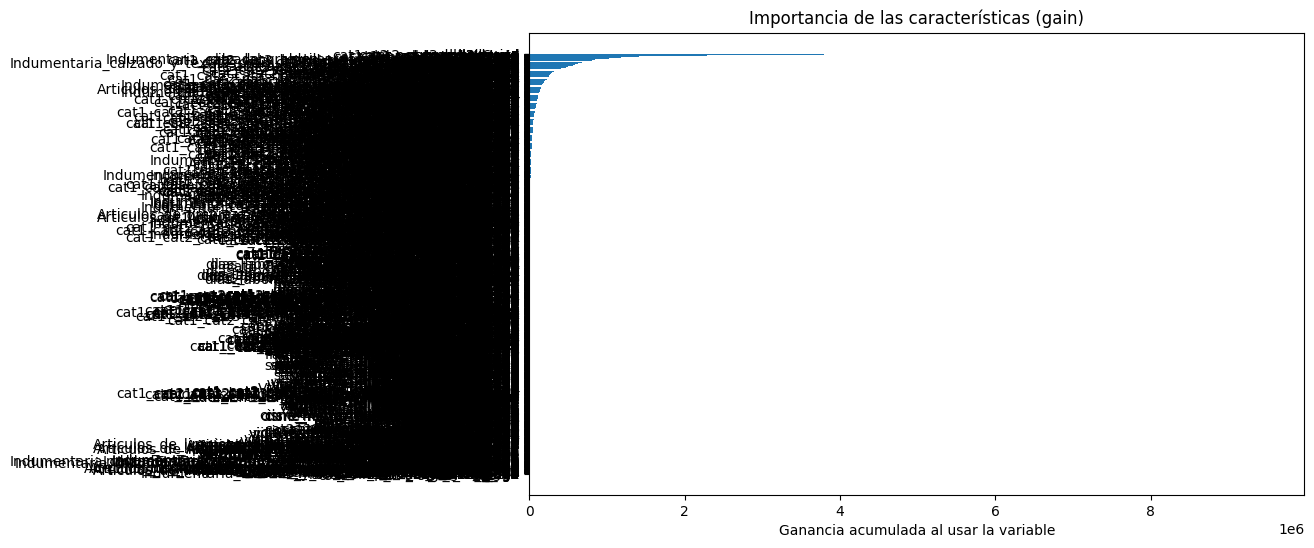

In [70]:
plt.figure(figsize=(10,6))
plt.barh(df_importances['feature'], df_importances['importance_gain'])
plt.xlabel('Ganancia acumulada al usar la variable')
plt.title('Importancia de las características (gain)')
plt.gca().invert_yaxis()
plt.show()

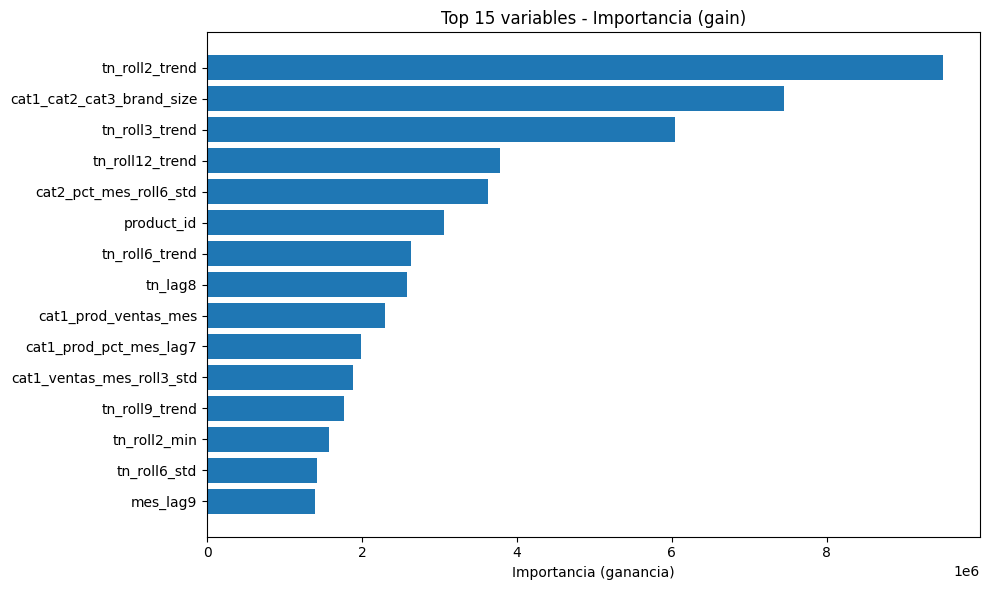

In [71]:
top = df_importances.sort_values('importance_gain', ascending=False).head(15)

plt.figure(figsize=(10,6))
plt.barh(top['feature'][::-1], top['importance_gain'][::-1])  # Invierte para mayor arriba
plt.xlabel('Importancia (ganancia)')
plt.title('Top 15 variables - Importancia (gain)')
plt.tight_layout()
plt.show()

In [72]:
df_36 = df_cluster_X[df_cluster_X['date_mes'] == '2019-12'].copy()

# Escalar solo num_cols
for col in num_cols:
    tipo, val = scalers[col]
    if tipo == 'std':
        df_36[col] = df_36[col] / val
    elif tipo == 'mean':
        df_36[col] = df_36[col] / val
    # else: no escala

KeyError: 'tn_pred_38'

In [73]:
# Label encoding para categóricas (manejar categorías nuevas con cuidado)
for col in categorical_cols:
    le = le_dict[col]
    vals = df_36[col].astype(str).fillna('missing')
    # Si aparecen categorías nuevas, las convertimos a -1 para evitar error
    df_36[col] = vals.map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

X_36 = df_36[num_cols + categorical_cols]

KeyError: "['tn_pred_38', 'tn_seed_17', 'tn_seed_53'] not in index"

In [74]:
X_36.shape

(1233, 2048)

In [75]:
# Predecimos la diferencia tn_38 - tn_36
pred_diff = gbm_final.predict(X_36)

# Reconstruimos la predicción absoluta para mes 38
df_36['tn_pred_38'] = df_36['tn'] + pred_diff

# Mostrar resultados
print(df_36[['p_id', 'tn', 'tn_pred_38']].head())

      p_id        tn  tn_pred_38
35   20001  1504.689    1646.180
71   20002  1087.309    1289.675
107  20003   892.501     757.718
143  20004   637.900     584.252
179  20005   593.244     858.063


In [76]:
df_result = df_36[['p_id', 'tn_pred_38']].copy()
df_result.head()

,p_id,tn_pred_38
35,20001,1646.180
71,20002,1289.675
107,20003,757.718
143,20004,584.252
179,20005,858.063


In [77]:
df_historia.head()

,product_id,min
0,20001,798.016
1,20002,505.886
2,20003,525.826
3,20004,415.525
4,20005,329.429


In [78]:
df_37= df_36.copy()
df_37.shape

(1233, 2056)

In [79]:
SEEDS = [17,53,101,199,281,397,503,619,733,853,967,1087,1223,1361,1489]
#SEEDS = [17,53]

for current_seed in SEEDS:
    final_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': current_seed,
    })

    lgb_full = lgb.Dataset(X, label=y, categorical_feature=categorical_cols)
    gbm_final = lgb.train(
        final_params,
        lgb_full,
        num_boost_round=1000,
        #verbose_eval=100
    )
    # Predecimos la diferencia tn_38 - tn_36
    pred_diff = gbm_final.predict(X_36)
    df_temp = pd.DataFrame()
    seed_str=str(current_seed)
    df_37['tn_seed_'+ seed_str] = df_36['tn'] + pred_diff


print(df_37.shape)

(1233, 2071)


In [56]:
#df_result_seeds = df_37[['p_id', 'tn_pred_38','tn_seed_17','tn_seed_53']].copy()
#df_result_seeds.head()

,p_id,tn_pred_38,tn_seed_17,tn_seed_53
35,20001,1754.484,1657.111,1701.637
71,20002,1263.830,1197.286,1192.212
107,20003,866.150,927.864,936.917
143,20004,697.720,736.632,683.478
179,20005,740.096,768.574,853.534


In [80]:
df_result_seeds = df_37[['p_id', 'tn_pred_38','tn_seed_17','tn_seed_53','tn_seed_101','tn_seed_199','tn_seed_281','tn_seed_397','tn_seed_503','tn_seed_619','tn_seed_733','tn_seed_853','tn_seed_967','tn_seed_1087','tn_seed_1223','tn_seed_1361','tn_seed_1489']].copy()
df_result_seeds.head()

,p_id,tn_pred_38,tn_seed_17,tn_seed_53,tn_seed_101,tn_seed_199,tn_seed_281,tn_seed_397,tn_seed_503,tn_seed_619,tn_seed_733,tn_seed_853,tn_seed_967,tn_seed_1087,tn_seed_1223,tn_seed_1361,tn_seed_1489
35,20001,1646.180,1635.293,1714.565,1735.714,1554.374,1761.274,1643.102,1626.467,1648.797,1575.617,1668.253,1553.190,1699.592,1668.241,1596.153,1569.890
71,20002,1289.675,1165.480,1181.492,1261.607,1193.114,1134.664,1169.346,1070.351,1183.124,1188.613,1235.316,1187.407,1180.917,1102.388,1138.386,1090.823
107,20003,757.718,806.058,846.658,821.785,753.195,914.245,848.343,847.337,757.336,755.122,736.381,842.780,924.867,806.475,829.408,801.268
143,20004,584.252,611.100,633.543,675.104,561.649,674.145,650.476,695.822,493.542,641.961,523.491,681.168,660.233,622.357,706.363,516.178
179,20005,858.063,872.293,890.442,829.328,820.534,835.480,751.177,842.586,778.254,846.776,897.902,821.472,919.181,841.910,806.064,778.934


In [81]:
# 1. Detectar la(s) columna(s) tipo string (object); asumir que solo hay una
str_cols = df_result_seeds.select_dtypes(include='object').columns.tolist()  # Ej: ['nombre']

# 2. Detectar las columnas numéricas
num_cols = df_result_seeds.select_dtypes(include='number').columns.tolist()  # Ej: ['valor1', 'valor2', 'valor3']

# 3. Calcular el promedio de las columnas numéricas por fila y crear la columna 'tn'
df_result_seeds['tn'] = df_result_seeds[num_cols].mean(axis=1)

# 4. Dejar solo la columna string y la columna 'tn'
df_sem = df_result_seeds[str_cols + ['tn']]

# Ahora tu DataFrame se ve así:
#   nombre   tn
# 0    Ana  4.0
# 1   Luis  5.0
# 2    Eva  6.0

# Opcional: imprime el resultado
print(df_sem.head())

      p_id        tn
35   20001  1643.544
71   20002  1173.294
107  20003   815.561
143  20004   620.711
179  20005   836.900


In [82]:
df_sem = df_sem.rename(columns={'p_id': 'product_id'})
df_sem['product_id'] = df_sem['product_id'].astype(int)

In [83]:
df_historia.dtypes

,0
product_id,int64
min,float64


In [84]:
# es muy raro que el mismo comprador compre menos de lo que ha comprado, y mucho menos puede comprar negativo
# Unimos ambos DataFrames usando product_cust_id como llave
df_result_1 = pd.merge(df_sem, df_historia[['product_id', 'min']], on='product_id', how='inner')

# Definimos la función para calcular el forecast según las reglas dadas
def calcular_forecast(row):
    tn_pred = row['tn']
    min_val = row['min']
    if tn_pred > min_val:
        return tn_pred
    elif tn_pred > (min_val / 2) and tn_pred <= min_val:
        return min_val
    else:
        return 0

# Aplicamos la función para calcular la nueva columna 'forecast'
df_result_1['forecast'] = df_result_1.apply(calcular_forecast, axis=1)

# Si solo quieres quedarte con product_cust_id y forecast:
df_result_1 = df_result_1[['product_id', 'forecast']]

In [85]:
df_result_1.head()

,product_id,forecast
0,20001,1643.544
1,20002,1173.294
2,20003,815.561
3,20004,620.711
4,20005,836.900


In [86]:
df_result_1.shape

(1233, 2)

In [87]:
# Merge para obtener el promedio solo para los product_id que están en productos_validar
df_validar = productos_validar.merge(
    df_result_1,
    on='product_id',
    how='left'
)

# Ahora df_validar_promedio tendrá dos columnas: product_id y tn_prom_2018
print(df_validar.head())

   product_id  forecast
0       20001  1643.544
1       20002  1173.294
2       20003   815.561
3       20004   620.711
4       20005   836.900


In [88]:
# le cambio el nombre de mean a tn
df_validar.rename(columns={'forecast': 'tn'}, inplace=True)
df_validar.head()

,product_id,tn
0,20001,1643.544
1,20002,1173.294
2,20003,815.561
3,20004,620.711
4,20005,836.900


In [89]:
df_validar.to_csv(DATOS_DIR +'df_full_prod_lgbm_V6.csv', index=False)